### Import Modules

In [35]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Activation, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dropout

# So we can see the output of multiple variables in a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

## Data Consolidation
### Load lines from CSV file and split Train/Test
* 1) Take a peek at the folders that contain the driving data and display stats
* 2) Consolidate/append all the CSV files into a single list `lines`
* 3) We will NOT augment or trim down any of the image data at this point

Format of `lines`:
```python
[
    [part1, part2, ..., part7]
    ... <many rows here>
    [part1, part2, ..., part7]
]
```

In [451]:
from os import walk, path
from time import time
from csv import reader

def consolidate(path_to_folders, print_verbose=True):

    path_to_files = []
    lines = []

    # print extra stuff like the root path, etc
    if print_verbose:
        for a, b, c in walk(path_to_folders):
            print('root-------')
            print(a, '\n')
            print('\tdirs-------')
            for dir in b:
                # Skip the IMG folders
                if 'IMG' in dir: break
                # Create a complete path to each folder
                print('\t\t', dir)
            print('\t\t\tfiles-------')
            print('\t\t\tfile count = {}'.format(len(c)))
            [print('\t\t\t\t', (file)) for file in c if 'csv' in file]
            file = [file for file in c if 'csv' in file]

    # Create list of full csv file paths
    for a, b, c in walk(path_to_folders):
        for file in c:
            if 'csv' in file:
                path_to_files.append(path.join(a, file))

    # Append lines of every CSV file to the list lines
    for file in path_to_files:
        folder_to_parse = file.split('\\')[-2]
        
        line_count = len(lines)
            
        print('\nParsing \t\t==> {}'.format(folder_to_parse))

        start_time = time()
        with open(file, 'r', encoding='UTF-8') as csvfile:
            csv_reader = reader(csvfile)
            next(csv_reader, None)  # skip header
            
            for line in csv_reader:
                    
                # rename the folder path since we have multiple folders (clockwise, corrections, etc.)
                line[0] = image_path + '\\' + folder_to_parse + '\\' + 'IMG\\' + line[0].split('\\')[-1]

                # Udacity folder has a different syntax, and is the only folder with Left, Right camera images
                if 'udacity' in folder_to_parse:
                    dice = np.random.randint(6)
                    if ('0.00' in line[3]): 
                        if dice < 1: break                    
                    line[0] = image_path + '\\' + folder_to_parse + '\\' + 'IMG\\' + line[0].split('/')[-1]
                    line[1] = image_path + '\\' + folder_to_parse + '\\' + 'IMG\\' + line[1].split('/')[-1]
                    line[2] = image_path + '\\' + folder_to_parse + '\\' + 'IMG\\' + line[2].split('/')[-1]
                
                lines.append(line)
                
        print('Length of Samples \t==> {:6}'.format((len(lines)-line_count), align='>'))
        time_in_ms = (time()-start_time)*1000
        print('Length of Lines \t==> {:6}'.format((len(lines)), align='>'))
        print('Done! Elapsed time(ms) \t==> {0:6.0f}'.format((time_in_ms), align='>'))

    return lines

In [452]:
# image_path = r'D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\ricky'
image_path = r'C:\Users\avion105\Documents\SDC\p3-behavioural-cloning\carnd-behavioral-cloning-p3\ricky\ricky'

lines = []
lines = consolidate(image_path, print_verbose=False)
print('\nNumber of unprocessed images ==> ', len(lines))
assert len(lines) > 0, "You got no lines, Lt. Data!"
train_samples, validation_samples = train_test_split(lines, test_size=0.2)


Parsing 		==> clockwise
Length of Samples 	==>   1252
Length of Lines 	==>   1252
Done! Elapsed time(ms) 	==>      7

Parsing 		==> counter-clockwise
Length of Samples 	==>    776
Length of Lines 	==>   2028
Done! Elapsed time(ms) 	==>      4

Parsing 		==> extra-turns
Length of Samples 	==>   2416
Length of Lines 	==>   4444
Done! Elapsed time(ms) 	==>     10

Parsing 		==> extra-turns-2
Length of Samples 	==>   3686
Length of Lines 	==>   8130
Done! Elapsed time(ms) 	==>     21

Parsing 		==> turn-corrections
Length of Samples 	==>    199
Length of Lines 	==>   8329
Done! Elapsed time(ms) 	==>     17

Parsing 		==> udacity
Length of Samples 	==>   2293
Length of Lines 	==>  10622
Done! Elapsed time(ms) 	==>     27

Number of unprocessed images ==>  10622


### Visualize Data Distribution

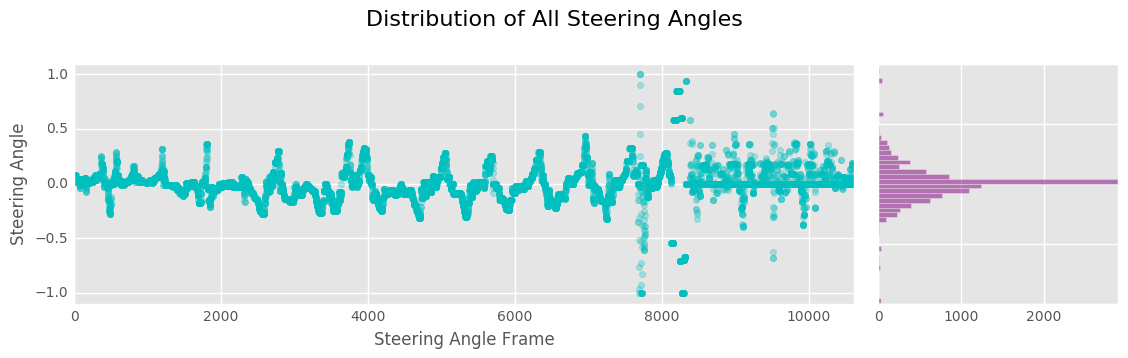

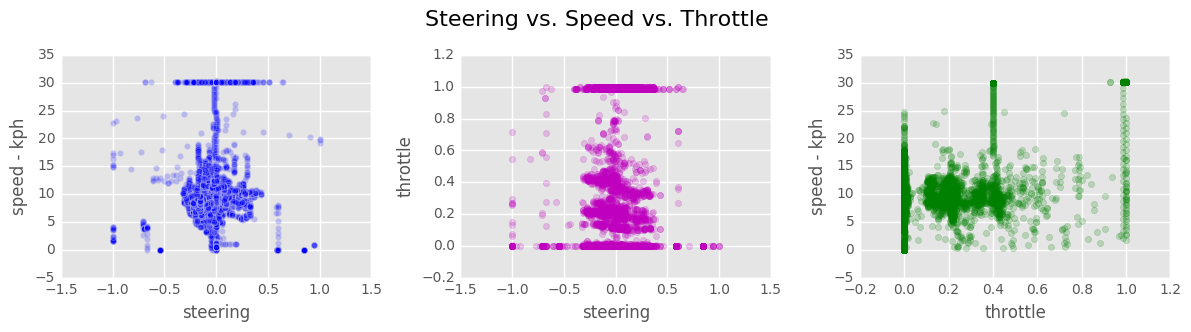

In [453]:
# create idividual lists from conslidated list 'lines'
steer = [float(lines[x][3]) for x in range(len(lines))]
throttle = [float(lines[x][4]) for x in range(len(lines))]
brake = [float(lines[x][5]) for x in range(len(lines))]
speed = [float(lines[x][6]) for x in range(len(lines))]

""" H I S T O G R A M S """
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.8
bottom_h = left_h = left + width + 0.02
rect_scatter = [left, bottom, width, height]
rect_histy = [left_h, bottom, 0.2, height]

# setup main histogram plot
plt.figure(figsize=(12,3))
plt.suptitle('Distribution of All Steering Angles', fontsize=16, y=1.08)
axScatter = plt.axes(rect_scatter)
plt.xlim(0, len(steer))
plt.ylim(-1.1,1.1)
plt.xlabel('Steering Angle Frame')
plt.ylabel('Steering Angle')
axScatter.scatter([i for i,_ in enumerate(steer)], steer, color='c', alpha=0.3)

# setup side histogram plot
# no labels
from matplotlib.ticker import NullFormatter
# x ticks
rng = range(0, len(steer), 1000)
axHisty = plt.axes(rect_histy)
axHisty.set_xticks(rng)
axHisty.yaxis.set_major_formatter(NullFormatter())
axHisty.hist(steer, bins=50, orientation='horizontal', color='purple', alpha=0.5)

plt.show()

print()

""" S T E E R I N G  vs  S P E E D  vs  T H R O T T L E """
plt.figure(figsize=(12,3))
plt.suptitle('Steering vs. Speed vs. Throttle', fontsize=16, y=1.08)
plt.subplot(131)
plt.tight_layout()
plt.scatter(steer, speed, alpha=0.2)
plt.xlabel('steering')
plt.ylabel('speed - kph')

plt.subplot(132)
plt.tight_layout()
plt.scatter(steer, throttle, color='m', alpha=0.2)
plt.xlabel('steering')
plt.ylabel('throttle')

plt.subplot(133)
plt.tight_layout()
plt.scatter(throttle, speed, color='g', alpha=0.2)
plt.xlabel('throttle')
plt.ylabel('speed - kph')
plt.show();

### Create Generator Helper Functions

In [454]:
# Set values for resized input images
rows, cols = 64, 64
def resize(img):
    return cv2.resize(img, (rows, cols), cv2.INTER_AREA)

def convert_to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def flip(img):
    return cv2.flip(img, 1)

def translate(img, steer, trans_amt):
    pass

def add_left_right_cameras(csv_line, angle, str_offset=0.25): 
    if angle != 0.0: exit    
        
    left_pic = cv2.imread(csv_line[1])
    right_pic = cv2.imread(csv_line[2])
    
    assert left_pic !=None, 'Looks like you may have the wrong IMG destination{}'.format(csv_line[1])
    assert right_pic !=None, 'Looks like you may have the wrong IMG destination{}'.format(csv_line[2])
        
    new_angle_left_pic = angle + str_offset
    new_angle_right_pic = angle - str_offset
    
    return left_pic, new_angle_left_pic, right_pic, new_angle_right_pic

### Create Generator

In [455]:
def generator(samples, batch_size=16):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:

                image = cv2.imread(batch_sample[0])
                angle = float(batch_sample[3])
                
                assert image !=None, 'Looks like you may have the wrong IMG destination\n{batch}'.format(batch_sample[0])
                
                left_right = False
                dice = np.random.randint(2)
                if 'udacity' in batch_sample[0]:
                    
                    lf_pic, lf_ang, rt_pic, rt_ang = add_left_right_cameras(batch_sample, angle)
                    left_right = True
                
                # Process center camera
                image = convert_to_hsv(image)
                image = resize(image)
                # image.shape should be (320, 160, 1)
                # so we only train on the S channel of the HSV image
                images.append(image[...,1,None])
                angles.append(angle)
                
                # Flip images and steering angles
                image_flip = flip(image)
                images.append(image_flip[..., 1, None])
                angles.append(angle*-1.0)
                
                # Process Left camera
                if left_right:
                    lf_pic_hsv = convert_to_hsv(lf_pic)
                    lf_pic_resize = resize(lf_pic_hsv)
                    images.append(lf_pic_resize[...,1,None])
                    angles.append(lf_ang)
                    # Flip
                    images.append(flip(lf_pic_resize)[...,1,None])
                    angles.append(lf_ang*-1.0)
                
                # Process Right camera
                if left_right:
                    rt_pic_hsv = convert_to_hsv(rt_pic)
                    rt_pic_resize = resize(rt_pic_hsv)
                    images.append(rt_pic_resize[...,1,None])
                    angles.append(rt_ang)
                    # Flip
                    images.append(flip(rt_pic_resize)[...,1,None])
                    angles.append(rt_ang*-1.0)                    
                
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

### Plot Image Processing Steps

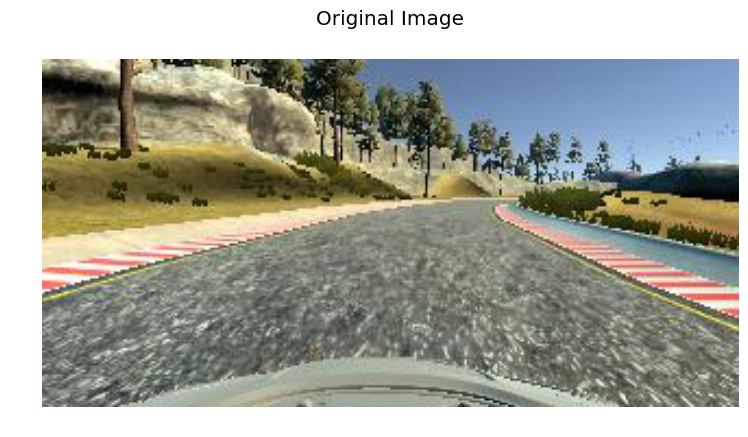

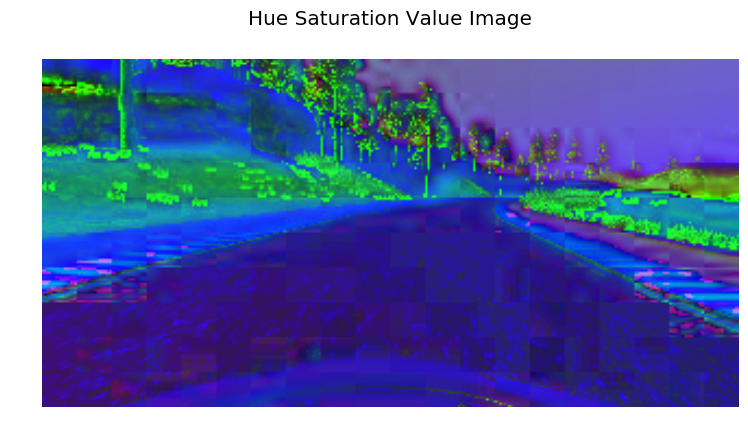

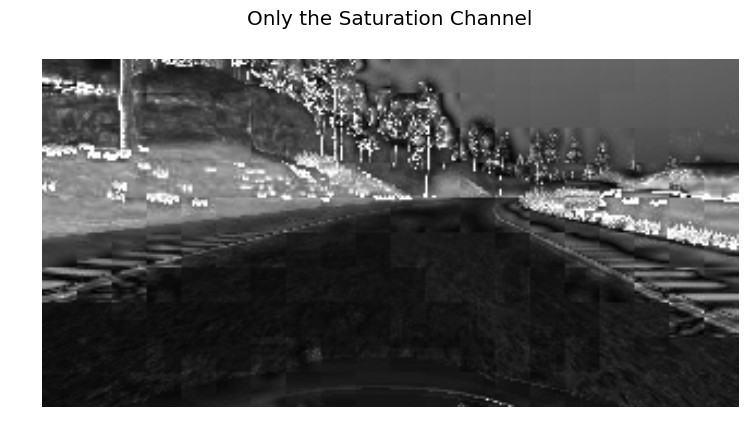

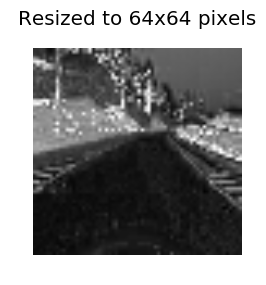

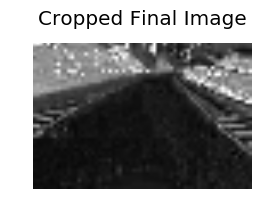

In [435]:
img = cv2.imread(r"D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\ricky\clockwise\IMG\center_2017_03_18_11_39_30_788.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.style.use('ggplot')

plt.imshow(img)
plt.axis('off')
plt.title('Original Image', y=1.08)
plt.savefig('write-up\\original-image.png', transparent=True)
plt.show()


img = convert_to_hsv(img)
plt.imshow(img)
plt.axis('off')
plt.title('Hue Saturation Value Image', y=1.08)
plt.savefig('write-up\\hsv-image.png', transparent=True)
plt.show()


img = img[:,:,1]
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Only the Saturation Channel', y=1.08)
plt.savefig('write-up\\only-saturation-image.png', transparent=True)
plt.show()

img = resize(img)
plt.figure(figsize=(2.5,2.5))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Resized to 64x64 pixels', y=1.08)
plt.savefig('write-up\\resized-image.png', transparent=True)
plt.show()

img = img[17:60,:]
plt.figure(figsize=(2.5,2.5))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Cropped Final Image', y=1.08)
plt.savefig('write-up\\cropped-final-image.png', transparent=True)
plt.show();


### Plot Steering Angle Distribution for Randomly Chosen Batches

100%|████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


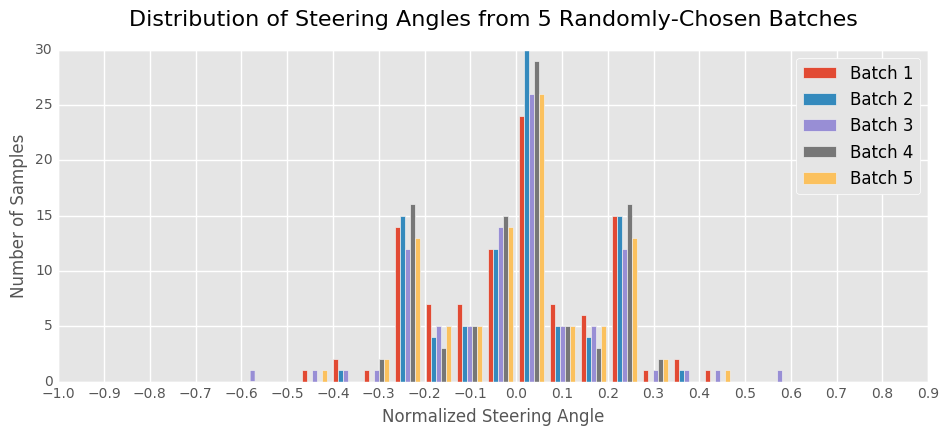

In [456]:
train_generator = generator(shuffle(train_samples), batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

X, y = next(train_generator)

batches = []
for i in tqdm(range(5)):
    _, y = next(train_generator)
    batches.append(y)

rng = np.arange(-1,1,.1)
plt.figure(figsize=(10,4))
plt.title('Distribution of Steering Angles from {} Randomly-Chosen Batches'.format(len(batches)), y=1.05, fontsize=16)
plt.xlabel('Normalized Steering Angle')
plt.ylabel('Number of Samples')
plt.hist(batches, bins=18)
plt.legend(['Batch 1', 'Batch 2', 'Batch 3', 'Batch 4', 'Batch 5'])
plt.xticks(rng)
plt.savefig('write-up/batch-distribution.png', transparent=False)
plt.show();

### Construct Model

In [320]:
model = Sequential()
model.add(Cropping2D(cropping=((14,5),(0,0)), input_shape=(64, 64, 1)))
model.add(Lambda(lambda x: x / 255.0 - 0.5))
model.add(Convolution2D(32, 5, 5, border_mode='same', name='conv1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(64, 5, 5, border_mode='same', name='conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(128, 3, 3, border_mode='same', name='conv3'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1))

### Train, Validate, and Save Model

In [328]:
model.compile(loss='mse', optimizer='adam')

nb_val_samples = len(validation_samples)
nb_max_epoch = 5
# save current/average validation loss
cur_val_loss = None
avg_val_loss = None
val_loss = []
loss = []

for epoch in range(nb_max_epoch):
    # Train Model with Generator
    history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples),
                       validation_data=validation_generator,
                       nb_val_samples=nb_val_samples, nb_epoch=1,
                       verbose=1)
    
    # save Validation Loss/Loss and decide to terminate training
    cur_val_loss = history_object.history['val_loss'][0]
    cur_loss = history_object.history['loss'][0]
    loss.append(cur_loss)
    val_loss.append(cur_val_loss)
    avg_val_loss = np.average(val_loss[-3:])
    print('avg_val_loss\t{:2.4f}'.format(avg_val_loss))
    print('cur_val_loss\t{:2.4f}'.format(cur_val_loss))
    # only enter if we completed 2 epochs and the current val loss is more than the avg_val_loss
    if (len(val_loss) > 2) & (cur_val_loss > avg_val_loss):
        print('\nThe current validation loss: {:2.5f} ' 
              'is higher than the average of the last three: {:2.5f}'
              .format(cur_val_loss, avg_val_loss))
        print('breaking!')
        break
    
    # Save the model everytime the validation loss decreases
    model.save('models\\model-ricky-jc-udacity-local-v1.h5')
    print('model saved!')

Epoch 1/1
7462/7407 [==============================] - 79s - loss: 0.0075 - val_loss: 0.0072
avg_val_loss	0.0072
cur_val_loss	0.0072
model saved!
Epoch 1/1
7472/7407 [==============================] - 78s - loss: 0.0054 - val_loss: 0.0064
avg_val_loss	0.0068
cur_val_loss	0.0064
model saved!
Epoch 1/1
7438/7407 [==============================] - 78s - loss: 0.0054 - val_loss: 0.0054
avg_val_loss	0.0063
cur_val_loss	0.0054
model saved!
Epoch 1/1
7408/7407 [==============================] - 77s - loss: 0.0049 - val_loss: 0.0052
avg_val_loss	0.0057
cur_val_loss	0.0052
model saved!
Epoch 1/1
7474/7407 [==============================] - 78s - loss: 0.0045 - val_loss: 0.0062
avg_val_loss	0.0056
cur_val_loss	0.0062
The current validation loss: 0.006is higher than the average of the last three: 0.006
breaking...


### Analyze the error loss of the model

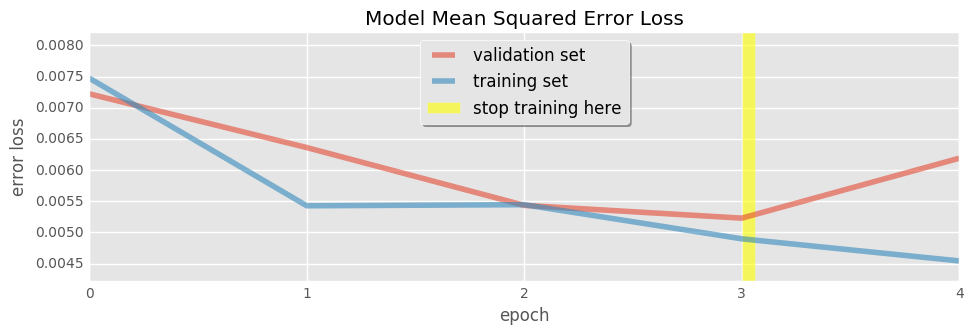

In [448]:
plt.figure(figsize=(10,3))
plt.plot(val_loss, alpha=0.6)
plt.plot(loss, alpha=0.6)
plt.title('Model Mean Squared Error Loss')
plt.xlabel('epoch')
plt.ylabel('error loss')
plt.xticks(range(0,len(val_loss),1))
plt.ylim(min(val_loss)-0.001, max(val_loss)+0.001)
plt.bar(len(val_loss)-2, max(val_loss)+0.001, width=0.06, color='yellow', alpha=0.6)
plt.legend(['validation set', 'training set', 'stop training here'], loc='best', shadow=True)
plt.savefig('write-up/model-mean-squared-error-loss.png', transparent=False)
plt.show();

### Verify steering angle

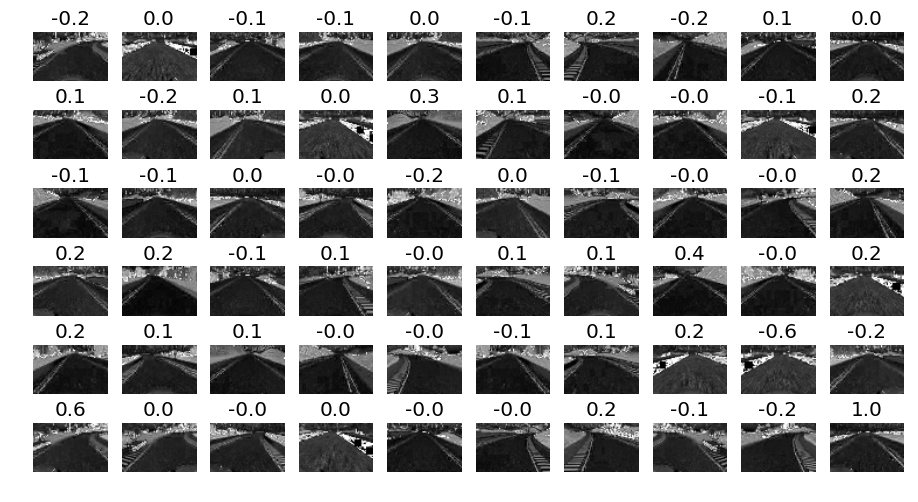

In [364]:
X = np.squeeze(X)

plt.figure(figsize=(10,5.5))
for i in range(60):
    plt.subplot(6,10,i+1)
    plt.imshow(X[i,17:60,:], cmap='gray')
    plt.title('{:2.1f}'.format(y[i]))
    plt.axis('off')
plt.show();

### Verify the Model can predict a single test image

In [457]:
from keras.models import load_model
model = load_model('models\\model-ricky-jc-udac-aws.h5')

img = cv2.imread(r"D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\ricky\clockwise\IMG\center_2017_03_18_11_39_30_788.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = convert_to_hsv(img)
img = resize(img)
img = img[...,1,None]

steering_angle = float(model.predict(img[None,...], batch_size=1))
steering_angle

0.1048145666718483

### Take a peak at the Convolutuion Layers

In [458]:
layer1 = Model(input=model.input, output=model.get_layer('conv1').output)
layer2 = Model(input=model.input, output=model.get_layer('conv2').output)
layer3 = Model(input=model.input, output=model.get_layer('conv3').output)


visual_layer1 = layer1.predict(img[None, ...])
visual_layer2 = layer2.predict(img[None, ...])
visual_layer3 = layer3.predict(img[None, ...])

In [459]:
visual_layer1.shape
visual_layer2.shape
visual_layer3.shape

arr_1, arr_2, arr_3  = [], [], []
layer_1, layer_2, layer_3 = [], [], []

for i in range(32):
    arr_1.append(visual_layer1[0, :, :, i])
for i in range(64):
    arr_2.append(visual_layer2[0, :, :, i])
for i in range(128):
    arr_3.append(visual_layer3[0, :, :, i])
pass;

### Convolution Layer 1 Feature Maps

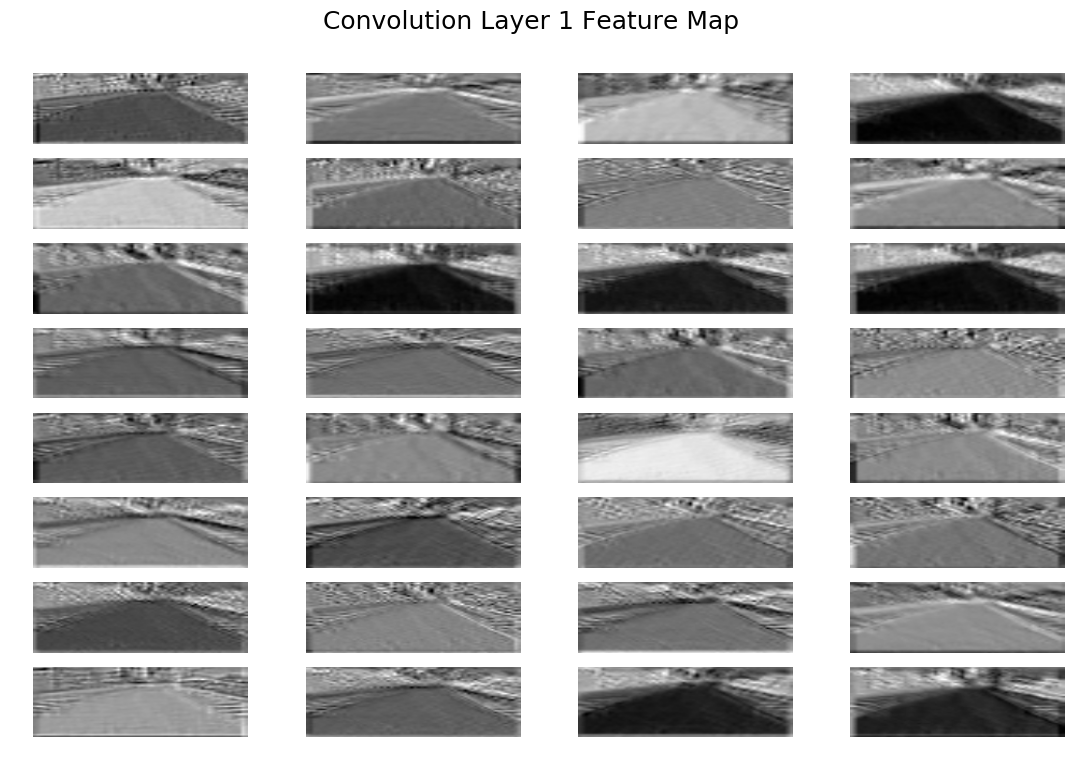

In [460]:
plt.figure(figsize=(12,8))
plt.suptitle('Convolution Layer 1 Feature Map', fontsize=18)
for i in range(32):
    plt.subplot(8, 4, i+1)
    temp = arr_1[i]
    temp = cv2.resize(temp, (200, 66), cv2.INTER_AREA)
    plt.imshow(temp, cmap='gray')
    plt.axis('off')
plt.savefig('write-up/conv-layer-1.png', transparent=True)
plt.show();

### Convolution Layer 2 Feature Maps

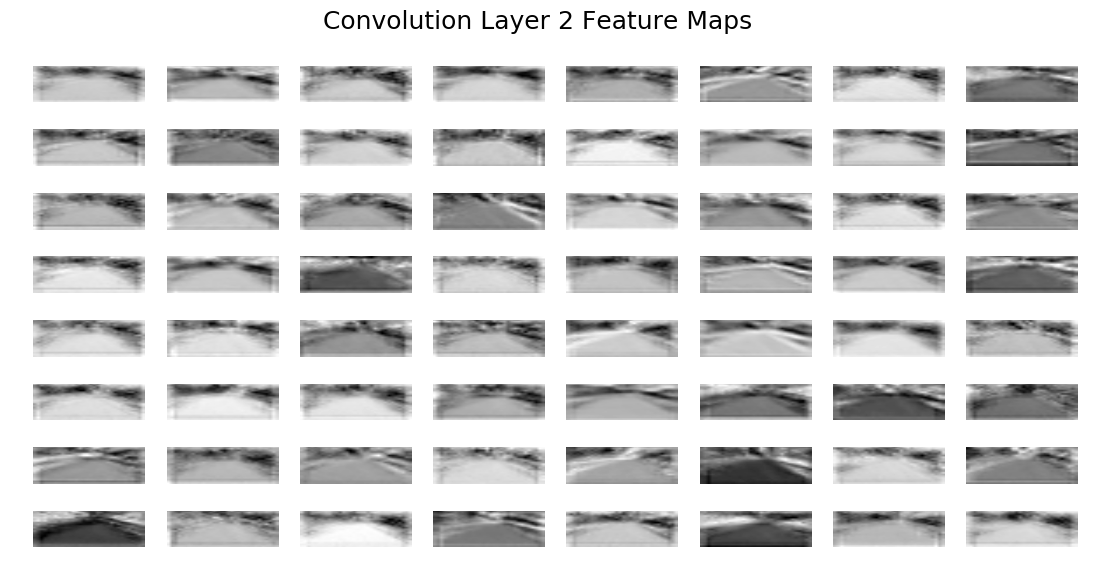

In [461]:
plt.figure(figsize=(12,6))
plt.suptitle('Convolution Layer 2 Feature Maps', fontsize=18)
for i in range(64):
    plt.subplot(8, 8, i+1)
    temp = arr_2[i]
    temp = cv2.resize(temp, (200, 66), cv2.INTER_AREA)
    plt.imshow(temp, cmap='gray')
    plt.axis('off')
plt.savefig('write-up/conv-layer-2.png', transparent=True)
plt.show();

### Convolution Layer 3 Feature Maps

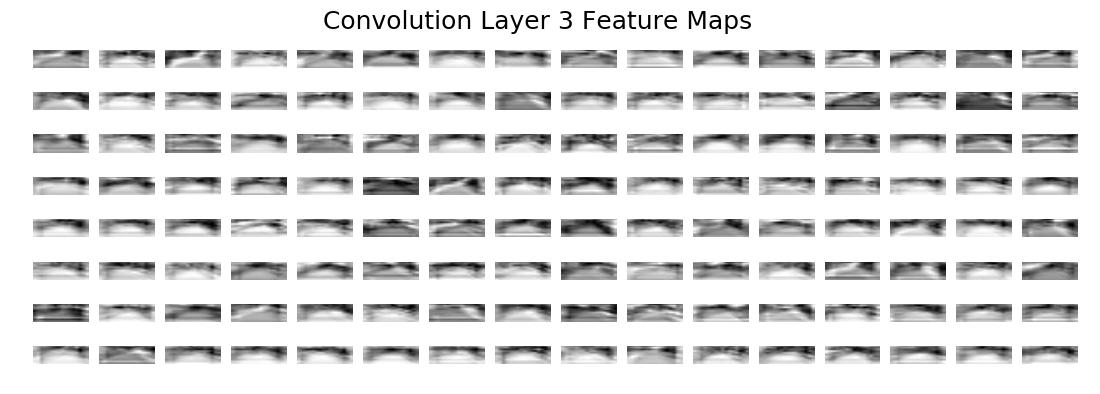

In [462]:
plt.figure(figsize=(12,4))
plt.suptitle('Convolution Layer 3 Feature Maps', fontsize=18)
for i in range(128):
    plt.subplot(8, 16, i+1)
    temp = arr_3[i]
    temp = cv2.resize(temp, (200, 66), cv2.INTER_AREA)
    plt.imshow(temp, cmap='gray')
    plt.axis('off')
plt.savefig('write-up/conv-layer-3.png', transparent=True)
plt.show();